In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df_wind = pd.read_csv('HEFTcom24\data\wind.csv')
# df_solar = pd.read_csv('HEFTcom24\data\solar.csv')
# df_demand = pd.read_csv('HEFTcom24\data\demand.csv')

Wind

In [3]:
df_wind.drop(columns=['Unnamed: 0','Solar_MWh_credit','Solar_MW','Solar_capacity_mwp','Solar_installedcapacity_mwp'], inplace=True)
df_wind

,valid_time,reference_time,RelativeHumidity_dwd,Temperature_dwd,WindDirection_dwd,WindDirection:100_dwd,WindSpeed_dwd,WindSpeed:100_dwd,RelativeHumidity_ncep,Temperature_ncep,...,WindDirection:100_ncep,WindSpeed_ncep,WindSpeed:100_ncep,dtm,MIP,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213745,15.416670,61.588080,62.085180,10.043627,11.802604,84.066670,15.450012,...,58.721077,9.116803,11.338992,2020-09-20 00:00:00+00:00,20.06,996.284,2.50000,0.0,32.17,498.142
1,2020-09-20 00:30:00+00:00,2020-09-20 00:00:00+00:00,85.012250,15.412510,61.203667,61.726974,9.905537,11.648819,84.433334,15.397076,...,58.494644,9.314931,11.516161,2020-09-20 00:30:00+00:00,19.77,957.576,15.00000,0.0,32.17,478.788
2,2020-09-20 01:00:00+00:00,2020-09-20 00:00:00+00:00,84.810770,15.408349,60.819256,61.368774,9.767447,11.495033,84.800000,15.344140,...,58.268215,9.513059,11.693331,2020-09-20 01:00:00+00:00,28.68,941.044,47.95000,0.0,32.00,470.522
3,2020-09-20 01:30:00+00:00,2020-09-20 00:00:00+00:00,84.357880,15.451218,60.511030,61.111040,9.631039,11.354128,84.933334,15.305976,...,59.550636,9.587589,11.716687,2020-09-20 01:30:00+00:00,28.97,964.366,29.13000,0.0,32.00,482.183
4,2020-09-20 02:00:00+00:00,2020-09-20 00:00:00+00:00,83.905000,15.494086,60.202800,60.853306,9.494630,11.213223,85.066666,15.267812,...,60.833060,9.662121,11.740044,2020-09-20 02:00:00+00:00,28.19,918.432,28.95000,0.0,31.99,459.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529625,2024-05-19 21:30:00+00:00,2024-05-19 00:00:00+00:00,91.634130,11.190109,21.214108,21.933590,6.882957,8.258531,93.683334,11.047282,...,22.433960,6.752734,9.066019,2024-05-19 21:30:00+00:00,77.40,227.518,56.20000,0.0,76.81,113.759
529626,2024-05-19 22:00:00+00:00,2024-05-19 00:00:00+00:00,91.232635,11.127069,22.417616,22.716902,7.040593,8.282218,94.700000,10.946550,...,22.568020,6.822509,9.019323,2024-05-19 22:00:00+00:00,80.82,197.090,102.00023,0.0,71.11,98.545
529627,2024-05-19 22:30:00+00:00,2024-05-19 00:00:00+00:00,90.249340,11.237669,22.327656,22.829685,6.842084,8.272179,95.016660,10.785738,...,21.831242,7.013203,8.877809,2024-05-19 22:30:00+00:00,75.69,171.306,99.00000,0.0,71.11,85.653
529628,2024-05-19 23:00:00+00:00,2024-05-19 00:00:00+00:00,89.266040,11.348270,22.237694,22.942470,6.643576,8.262139,95.333336,10.624926,...,21.094461,7.203896,8.736294,2024-05-19 23:00:00+00:00,78.98,163.164,106.44988,0.0,66.51,81.582


In [28]:
df_wind.columns

Index(['valid_time', 'reference_time', 'RelativeHumidity_dwd',
       'Temperature_dwd', 'WindDirection_dwd', 'WindDirection:100_dwd',
       'WindSpeed_dwd', 'WindSpeed:100_dwd', 'RelativeHumidity_ncep',
       'Temperature_ncep', 'WindDirection_ncep', 'WindDirection:100_ncep',
       'WindSpeed_ncep', 'WindSpeed:100_ncep', 'dtm', 'MIP', 'Wind_MW',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit'],
      dtype='object')

In [8]:
def add_time_features(df):
    df['valid_time'] = pd.to_datetime(df['valid_time'])
    df['reference_time'] = pd.to_datetime(df['reference_time'])

    df['hour'] = df['valid_time'].dt.hour
    df['day_of_week'] = df['valid_time'].dt.dayofweek
    df['month'] = df['valid_time'].dt.month
    df['season'] = df['month'] % 12 // 3
    # Time deltas
    df['forecast_horizon'] = (df['valid_time'] - df['reference_time']).dt.total_seconds() / 3600
    return df
def add_wind_features(df):
    # Wind shear (for both sources)
    df['wind_shear_dwd'] = df['WindSpeed:100_dwd'] - df['WindSpeed_dwd']
    df['wind_shear_ncep'] = df['WindSpeed:100_ncep'] - df['WindSpeed_ncep']
    
    # Wind direction difference
    df['direction_diff_dwd'] = np.minimum((df['WindDirection:100_dwd'] - df['WindDirection_dwd']) % 360,
                                         (df['WindDirection_dwd'] - df['WindDirection:100_dwd']) % 360)
    df['direction_diff_ncep'] = np.minimum((df['WindDirection:100_ncep'] - df['WindDirection_ncep']) % 360,
                                          (df['WindDirection_ncep'] - df['WindDirection:100_ncep']) % 360)
    
    # Wind power density (ρv³/2) - assuming standard air density
    df['wind_power_density_100_dwd'] = 0.5 * 1.225 * df['WindSpeed:100_dwd']**3
    df['wind_power_density_100_ncep'] = 0.5 * 1.225 * df['WindSpeed:100_ncep']**3
    return df
def calculate_air_density(df):
    # Constants
    R = 287.058  # Specific gas constant for dry air, J/(kg·K)
    
    # Convert temperature to Kelvin
    temp_k_dwd = df['Temperature_dwd'] + 273.15
    temp_k_ncep = df['Temperature_ncep'] + 273.15
    
    # Simple air density calculation
    df['air_density_dwd'] = 100000 / (R * temp_k_dwd)  # assuming standard pressure
    df['air_density_ncep'] = 100000 / (R * temp_k_ncep)
    return df
def add_model_agreement_features(df):
    # Difference between models
    df['wind_speed_model_diff'] = df['WindSpeed:100_dwd'] - df['WindSpeed:100_ncep']
    df['wind_direction_model_diff'] = np.minimum((df['WindDirection:100_dwd'] - df['WindDirection:100_ncep']) % 360,
                                                (df['WindDirection:100_ncep'] - df['WindDirection:100_dwd']) % 360)
    df['temperature_model_diff'] = df['Temperature_dwd'] - df['Temperature_ncep']
    df['humidity_model_diff'] = df['RelativeHumidity_dwd'] - df['RelativeHumidity_ncep']
    return df
def add_rolling_features(df, window=6):
    key_features = [
        'WindSpeed:100_dwd',
        'WindSpeed:100_ncep',
        'WindDirection:100_dwd',
        'WindDirection:100_ncep',
        'Temperature_dwd',
        'Temperature_ncep'
    ]
    
    for col in key_features:
        if col in df.columns:
            # Add rolling mean only for these key features
            df[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
            
            # For wind speed, also add standard deviation
            if 'WindSpeed' in col:
                df[f'{col}_rolling_std_{window}h'] = df[col].rolling(window=window).std()
    
    return df
def handle_missing_values(df):
    # For numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # For categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
    return df
from sklearn.preprocessing import StandardScaler

def scale_features(df, exclude_cols=['valid_time', 'reference_time']):
    scaler = StandardScaler()
    cols_to_scale = [col for col in df.columns if col not in exclude_cols]
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df, scaler

In [9]:
def process_wind_features(df):
    # Make a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Add all new features
    processed_df = add_time_features(processed_df)
    processed_df = add_wind_features(processed_df)
    processed_df = calculate_air_density(processed_df)
    processed_df = add_model_agreement_features(processed_df)
    processed_df = add_rolling_features(processed_df)
    
    # Handle missing values
    processed_df = handle_missing_values(processed_df)
    
    # Scale features
    # processed_df, scaler = scale_features(processed_df)
    
    return processed_df

In [10]:
df_wind1 = process_wind_features(df_wind)

In [15]:
df_wind2,_ = scale_features(df_wind1.drop(columns=['dtm','reference_time','valid_time']))

In [16]:
df_wind2

,RelativeHumidity_dwd,Temperature_dwd,WindDirection_dwd,WindDirection:100_dwd,WindSpeed_dwd,WindSpeed:100_dwd,RelativeHumidity_ncep,Temperature_ncep,WindDirection_ncep,WindDirection:100_ncep,...,temperature_model_diff,humidity_model_diff,WindSpeed:100_dwd_rolling_mean_6h,WindSpeed:100_dwd_rolling_std_6h,WindSpeed:100_ncep_rolling_mean_6h,WindSpeed:100_ncep_rolling_std_6h,WindDirection:100_dwd_rolling_mean_6h,WindDirection:100_ncep_rolling_mean_6h,Temperature_dwd_rolling_mean_6h,Temperature_ncep_rolling_mean_6h
0,0.314564,1.195437,-1.545796,-1.559559,0.609730,0.453389,0.254291,1.317087,-1.610707,-1.601947,...,-0.451911,0.041755,0.000000,0.000000,0.000000,0.000000,3.246239e-16,-3.263579e-16,0.000000,4.589976e-16
1,0.289829,1.194383,-1.550076,-1.563548,0.574185,0.421477,0.294276,1.303427,-1.610536,-1.604489,...,-0.394587,-0.061102,0.000000,0.000000,0.000000,0.000000,3.246239e-16,-3.263579e-16,0.000000,4.589976e-16
2,0.265097,1.193329,-1.554355,-1.567537,0.538640,0.389566,0.334260,1.289766,-1.610366,-1.607030,...,-0.337264,-0.163956,0.000000,0.000000,0.000000,0.000000,3.246239e-16,-3.263579e-16,0.000000,4.589976e-16
3,0.209502,1.204188,-1.557786,-1.570407,0.503528,0.360328,0.348800,1.279917,-1.594113,-1.592635,...,-0.242029,-0.270083,0.000000,0.000000,0.000000,0.000000,3.246239e-16,-3.263579e-16,0.000000,4.589976e-16
4,0.153909,1.215047,-1.561218,-1.573276,0.468416,0.331089,0.363340,1.270068,-1.577861,-1.578239,...,-0.146796,-0.376208,0.000000,0.000000,0.000000,0.000000,3.246239e-16,-3.263579e-16,0.000000,4.589976e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529625,1.102699,0.124793,-1.995250,-2.006658,-0.203842,-0.282022,1.302983,0.180901,-2.042286,-2.009281,...,-0.244868,-0.536883,-0.299462,-0.775187,-0.142077,-0.801893,-2.072801e+00,-2.065088e+00,0.195221,2.551497e-01
529626,1.053413,0.108824,-1.981852,-1.997936,-0.163265,-0.277106,1.413850,0.154906,-2.035637,-2.007776,...,-0.200571,-0.793619,-0.297320,-0.758968,-0.147079,-0.777704,-2.067920e+00,-2.061484e+00,0.167392,2.251053e-01
529627,0.932709,0.136840,-1.982853,-1.996680,-0.214362,-0.279190,1.448382,0.113406,-2.032469,-2.016047,...,0.118409,-1.028956,-0.293616,-0.756070,-0.156696,-0.705222,-2.062721e+00,-2.059885e+00,0.149684,1.937524e-01
529628,0.812004,0.164857,-1.983855,-1.995424,-0.265460,-0.281273,1.482915,0.071906,-2.029301,-2.024317,...,0.437389,-1.264297,-0.288350,-0.796717,-0.170928,-0.622687,-2.057205e+00,-2.060294e+00,0.142097,1.610910e-01


In [22]:
def forward_feature_selection(X, y, max_features=15):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    import numpy as np
    import pandas as pd
    
    # Initialize variables
    features_selected = []
    features_to_select = list(X.columns)
    best_scores = []
    correlations = []
    
    # Model to use
    model = LinearRegression()
    
    for i in range(max_features):
        best_score = float('-inf')
        best_feature = None
        
        # Try each feature not yet selected
        for feature in features_to_select:
            # Combine selected features with current candidate
            current_features = features_selected + [feature]
            
            # Create dataset with current features
            X_current = X[current_features]
            
            # Perform cross-validation
            scores = cross_val_score(model, X_current, y, cv=5, scoring='r2')
            avg_score = np.mean(scores)
            
            # Update if this is the best score
            if avg_score > best_score:
                best_score = avg_score
                best_feature = feature
        
        # Add best feature to selected features
        if best_feature:
            features_selected.append(best_feature)
            features_to_select.remove(best_feature)
            best_scores.append(best_score)
            
            # Fit model and get correlation for print
            X_current = X[features_selected]
            model.fit(X_current, y)
            y_pred = model.predict(X_current)
            mse = np.mean((y - y_pred) ** 2)
            correlation = np.corrcoef(y, y_pred)[0, 1]
            correlations.append(correlation)
            
            # Print results
            print(f"Step {i+1}:")
            print(f"Added feature: {best_feature}")
            print(f"R-squared score: {best_score:.4f}")
            print(f"MSE: {mse:.4f}")
            print(f"Correlation: {correlation:.4f}")
            print(f"Current features: {features_selected}")
            print("--------------------")
    
    # Create summary dataframe
    summary = pd.DataFrame({
        'Step': range(1, len(features_selected) + 1),
        'Added_Feature': features_selected,
        'R_Squared': best_scores,
        'Correlation': correlations
    })
    
    return summary, features_selected

# Example usage
def run_feature_selection(df, target_column, max_features=20):
    # Prepare data
    y = df[target_column]
    X = df.drop(columns=[target_column])
    
    # Remove any non-numeric columns
    X = X.select_dtypes(include=[np.number])
    
    # Run feature selection
    summary, selected_features = forward_feature_selection(X, y, max_features)
    
    return summary, selected_features

# Plot results
def plot_feature_selection_results(summary):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.plot(summary['Step'], summary['R_Squared'], label='R-Squared')
    plt.plot(summary['Step'], summary['Correlation'], label='Correlation')
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Feature Selection Results')
    plt.legend()
    plt.grid(True)
    plt.show()

# Full example of how to use
"""
# Assuming df is your dataframe and 'target' is your target column
summary, selected_features = run_feature_selection(df, 'target')
plot_feature_selection_results(summary)

# Print final selected features and their coefficients
final_model = LinearRegression()
X_final = df[selected_features]
final_model.fit(X_final, df['target'])

coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFinal Model Coefficients:")
print(coefficients)
"""

'\n# Assuming df is your dataframe and \'target\' is your target column\nsummary, selected_features = run_feature_selection(df, \'target\')\nplot_feature_selection_results(summary)\n\n# Print final selected features and their coefficients\nfinal_model = LinearRegression()\nX_final = df[selected_features]\nfinal_model.fit(X_final, df[\'target\'])\n\ncoefficients = pd.DataFrame({\n    \'Feature\': selected_features,\n    \'Coefficient\': final_model.coef_\n}).sort_values(by=\'Coefficient\', key=abs, ascending=False)\n\nprint("\nFinal Model Coefficients:")\nprint(coefficients)\n'

In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def decision_tree_feature_selection(X, y, max_features=15):
    # Initialize variables
    features_selected = []
    features_to_select = list(X.columns)
    best_scores = []
    feature_importances = []
    tree_depths = []
    mse_scores = []
    
    # Initialize model
    model = DecisionTreeRegressor(random_state=42, max_depth=12)
    
    for i in range(max_features):
        best_score = float('-inf')
        best_feature = None
        best_importance = None
        best_depth = None
        best_mse = float('inf')
        
        # Try each feature not yet selected
        for feature in features_to_select:
            current_features = features_selected + [feature]
            X_current = X[current_features]
            
            # Perform cross-validation
            scores = cross_val_score(model, X_current, y, cv=5, scoring='r2')
            avg_score = np.mean(scores)
            
            if avg_score > best_score:
                best_score = avg_score
                best_feature = feature
                
                # Fit model to get additional metrics
                model.fit(X_current, y)
                y_pred = model.predict(X_current)
                best_mse = mean_squared_error(y, y_pred)
                best_depth = model.get_depth()
                
                # Get feature importance for the best feature
                importances = dict(zip(current_features, model.feature_importances_))
                best_importance = importances[feature]
        
        # Add best feature
        if best_feature:
            features_selected.append(best_feature)
            features_to_select.remove(best_feature)
            best_scores.append(best_score)
            feature_importances.append(best_importance)
            tree_depths.append(best_depth)
            mse_scores.append(best_mse)
            
            # Print results
            print(f"Step {i+1}:")
            print(f"Added feature: {best_feature}")
            print(f"R-squared score: {best_score:.4f}")
            print(f"Feature importance: {best_importance:.4f}")
            print(f"Tree depth: {best_depth}")
            print(f"MSE: {best_mse:.4f}")
            print(f"Current features: {features_selected}")
            print("--------------------")
    
    # Create summary dataframe
    summary = pd.DataFrame({
        'Step': range(1, len(features_selected) + 1),
        'Added_Feature': features_selected,
        'R_Squared': best_scores,
        'Feature_Importance': feature_importances,
        'Tree_Depth': tree_depths,
        'MSE': mse_scores
    })
    
    return summary, features_selected

def plot_decision_tree_results(summary):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Decision Tree Feature Selection Results')
    
    # R-squared plot
    axs[0, 0].plot(summary['Step'], summary['R_Squared'])
    axs[0, 0].set_xlabel('Number of Features')
    axs[0, 0].set_ylabel('R-squared Score')
    axs[0, 0].set_title('R-squared vs Number of Features')
    axs[0, 0].grid(True)
    
    # Feature Importance plot
    axs[0, 1].bar(range(len(summary)), summary['Feature_Importance'])
    axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Feature Importance')
    axs[0, 1].set_title('Feature Importance of Added Features')
    
    # Tree Depth plot
    axs[1, 0].plot(summary['Step'], summary['Tree_Depth'])
    axs[1, 0].set_xlabel('Number of Features')
    axs[1, 0].set_ylabel('Tree Depth')
    axs[1, 0].set_title('Tree Depth vs Number of Features')
    axs[1, 0].grid(True)
    
    # MSE plot
    axs[1, 1].plot(summary['Step'], summary['MSE'])
    axs[1, 1].set_xlabel('Number of Features')
    axs[1, 1].set_ylabel('Mean Squared Error')
    axs[1, 1].set_title('MSE vs Number of Features')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_final_model(X, y, selected_features):
    model = DecisionTreeRegressor(random_state=42, max_depth=25)
    X_final = X[selected_features]
    model.fit(X_final, y)
    
    # Get feature importances
    importances = pd.DataFrame({
        'Feature': selected_features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFinal Model Analysis:")
    print(f"Tree Depth: {model.get_depth()}")
    print(f"Number of Leaves: {model.get_n_leaves()}")
    print("\nFeature Importances:")
    print(importances)
    
    return model, importances

def run_decision_tree_selection(df, target_column, max_features=15):
    # Prepare data
    y = df[target_column]
    X = df.drop(columns=[target_column])
    
    # Remove any non-numeric columns
    X = X.select_dtypes(include=[np.number])
    
    # Run feature selection
    summary, selected_features = decision_tree_feature_selection(X, y, max_features)
    
    # Plot results
    plot_decision_tree_results(summary)
    
    # Analyze final model
    final_model, importances = analyze_final_model(X, y, selected_features)
    
    return summary, selected_features, final_model, importances

# Example usage
"""
# Assuming df is your dataframe and 'target' is your target column
summary, selected_features, final_model, importances = run_decision_tree_selection(df, 'target')

# To get predictions from the final model:
X_final = df[selected_features]
predictions = final_model.predict(X_final)
"""

"\n# Assuming df is your dataframe and 'target' is your target column\nsummary, selected_features, final_model, importances = run_decision_tree_selection(df, 'target')\n\n# To get predictions from the final model:\nX_final = df[selected_features]\npredictions = final_model.predict(X_final)\n"

In [ ]:
df_wind2.drop(columns=['Wind_MW'])

In [ ]:
summary, selected_features = run_feature_selection(df_wind2.drop(columns=['Wind_MW']), 'Wind_MWh_credit')

Step 1:
Added feature: wind_power_density_100_dwd
R-squared score: 0.7380
Feature importance: 1.0000
Tree depth: 12
MSE: 0.2275
Current features: ['wind_power_density_100_dwd']
--------------------
Step 2:
Added feature: wind_power_density_100_ncep
R-squared score: 0.7623
Feature importance: 0.1791
Tree depth: 12
MSE: 0.1839
Current features: ['wind_power_density_100_dwd', 'wind_power_density_100_ncep']
--------------------
Step 3:
Added feature: WindSpeed:100_dwd_rolling_std_6h
R-squared score: 0.7717
Feature importance: 0.0096
Tree depth: 12
MSE: 0.1811
Current features: ['wind_power_density_100_dwd', 'wind_power_density_100_ncep', 'WindSpeed:100_dwd_rolling_std_6h']
--------------------
Step 4:
Added feature: boa_MWh
R-squared score: 0.7734
Feature importance: 0.0011
Tree depth: 12
MSE: 0.1814
Current features: ['wind_power_density_100_dwd', 'wind_power_density_100_ncep', 'WindSpeed:100_dwd_rolling_std_6h', 'boa_MWh']
--------------------
Step 5:
Added feature: WindSpeed:100_ncep
R-

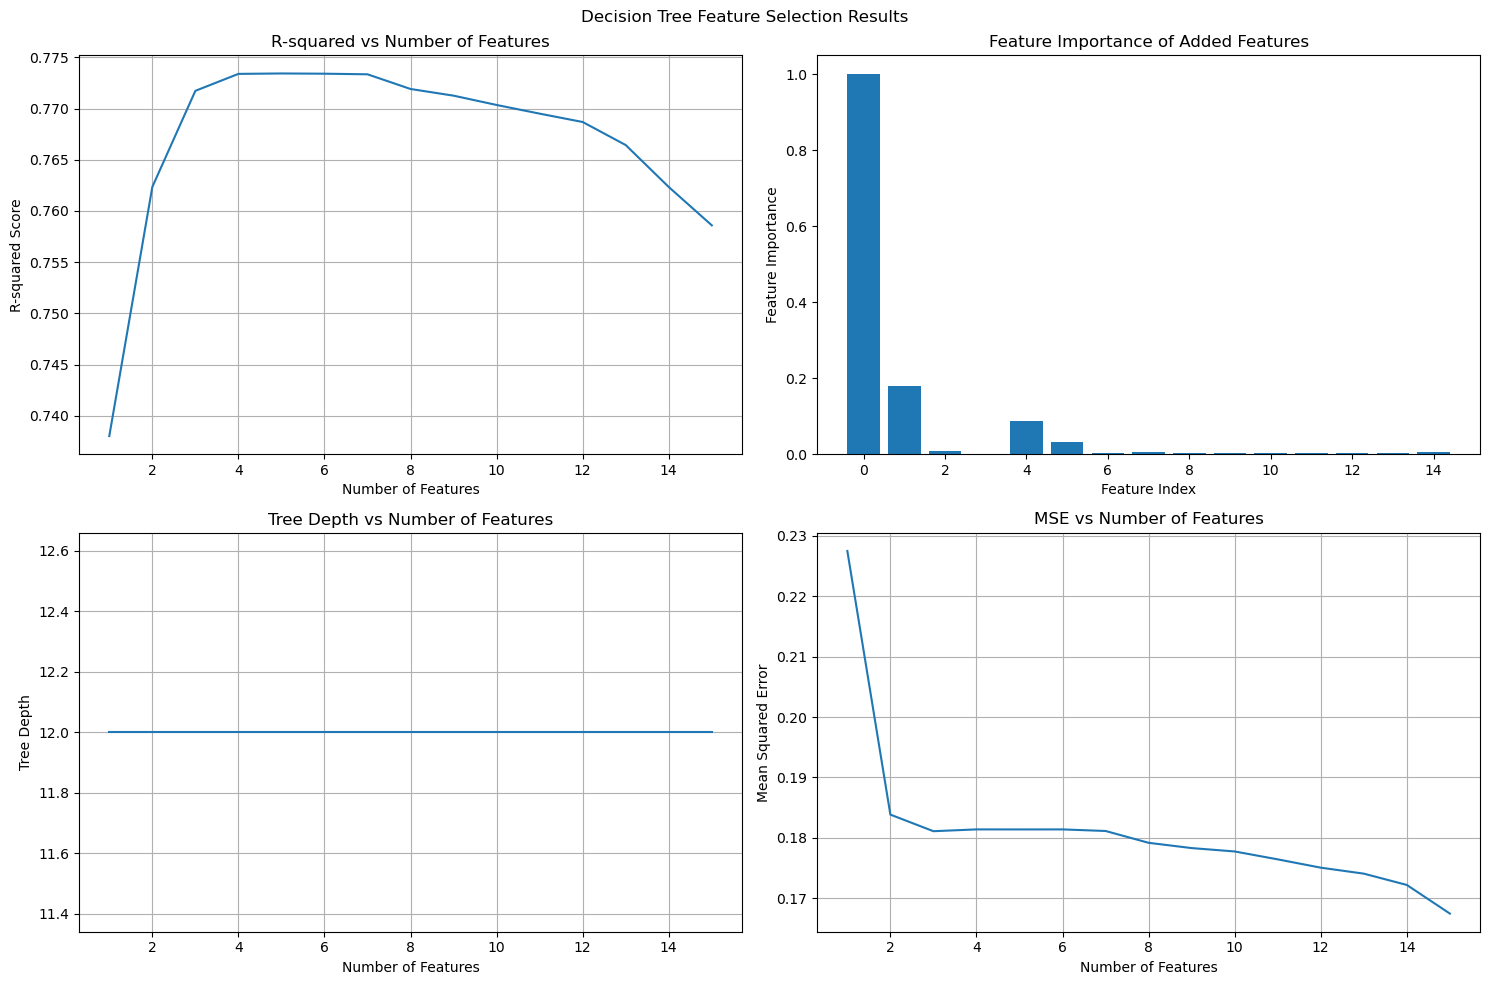


Final Model Analysis:
Tree Depth: 25
Number of Leaves: 232909

Feature Importances:
                               Feature  Importance
0           wind_power_density_100_dwd    0.668746
4                   WindSpeed:100_ncep    0.144959
5                    WindSpeed:100_dwd    0.028611
14                      WindSpeed_ncep    0.019912
13                 humidity_model_diff    0.017922
2     WindSpeed:100_dwd_rolling_std_6h    0.017096
7   WindSpeed:100_ncep_rolling_mean_6h    0.014668
12                                hour    0.014496
10           wind_direction_model_diff    0.014159
8    WindSpeed:100_ncep_rolling_std_6h    0.014014
11                    forecast_horizon    0.013509
9    WindSpeed:100_dwd_rolling_mean_6h    0.013349
6                wind_speed_model_diff    0.009222
1          wind_power_density_100_ncep    0.008579
3                              boa_MWh    0.000758


In [33]:
summary1, selected_features1, final_model, importances = run_decision_tree_selection(df_wind2.drop(columns=['Wind_MW']), 'Wind_MWh_credit')

In [18]:
df_wind.columns

Index(['valid_time', 'reference_time', 'RelativeHumidity_dwd',
       'Temperature_dwd', 'WindDirection_dwd', 'WindDirection:100_dwd',
       'WindSpeed_dwd', 'WindSpeed:100_dwd', 'RelativeHumidity_ncep',
       'Temperature_ncep', 'WindDirection_ncep', 'WindDirection:100_ncep',
       'WindSpeed_ncep', 'WindSpeed:100_ncep', 'dtm', 'MIP', 'Wind_MW',
       'SS_Price', 'boa_MWh', 'DA_Price', 'Wind_MWh_credit'],
      dtype='object')

In [4]:
# Display columns with NaN values and their counts
na_columns = df_wind.isna().sum()
na_columns = na_columns[na_columns > 0]
print(na_columns)

Series([], dtype: int64)


In [12]:
#correlation between features and Wind_MWh_credit
correlation = df_wind1.drop(columns=['dtm','reference_time','valid_time']).corr()['Wind_MWh_credit'].sort_values()
correlation

wind_direction_model_diff                -0.267201
direction_diff_dwd                       -0.175400
humidity_model_diff                      -0.165358
MIP                                      -0.150851
Temperature_ncep_rolling_mean_6h         -0.143564
Temperature_ncep                         -0.142823
DA_Price                                 -0.131504
Temperature_dwd_rolling_mean_6h          -0.127831
Temperature_dwd                          -0.125962
direction_diff_ncep                      -0.120320
SS_Price                                 -0.106251
boa_MWh                                  -0.074960
season                                   -0.067980
RelativeHumidity_dwd                     -0.050708
forecast_horizon                          0.000189
day_of_week                               0.000363
hour                                      0.014357
wind_speed_model_diff                     0.028372
RelativeHumidity_ncep                     0.054560
month                          

In [12]:
import plotly.express as px

# Calculate the relative variance
variance = df_wind.drop(columns=['dtm','reference_time','valid_time']).var()

# Calculate the relative variance
relative_variance = df_wind.drop(columns=['dtm','reference_time','valid_time']).var() / df_wind.drop(columns=['dtm','reference_time','valid_time']).mean()

# Convert the relative variance to a DataFrame for plotting
relative_variance_df = relative_variance.reset_index()
relative_variance_df.columns = ['Feature', 'Relative Variance']

# Plot the relative variance using Plotly
fig = px.bar(relative_variance_df, x='Feature', y='Relative Variance', title='Relative Variance of Each Feature', labels={'Feature': 'Features', 'Relative Variance': 'Relative Variance'})
fig.show()


In [11]:
df_wind.drop(columns=['dtm','reference_time','valid_time']).var() / df_wind.drop(columns=['dtm','reference_time','valid_time']).mean()

RelativeHumidity_dwd        0.802920
Temperature_dwd             1.456812
WindDirection_dwd          40.256727
WindDirection:100_dwd      39.897379
WindSpeed_dwd               1.966511
WindSpeed:100_dwd           2.414784
RelativeHumidity_ncep       1.028837
Temperature_ncep            1.451314
WindDirection_ncep         39.636826
WindDirection:100_ncep     39.398651
WindSpeed_ncep              1.801318
WindSpeed:100_ncep          2.332989
MIP                        70.832247
Wind_MW                   324.496956
SS_Price                  129.116524
boa_MWh                  -314.415653
DA_Price                   76.604535
Wind_MWh_credit           162.236392
dtype: float64

In [8]:
df_wind.drop(columns=['dtm','reference_time','valid_time']).var()

RelativeHumidity_dwd          66.362349
Temperature_dwd               15.584204
WindDirection_dwd           8069.283588
WindDirection:100_dwd       8064.889913
WindSpeed_dwd                 15.092709
WindSpeed:100_dwd             23.224530
RelativeHumidity_ncep         84.091752
Temperature_ncep              15.015713
WindDirection_ncep          7899.548149
WindDirection:100_ncep      7936.057195
WindSpeed_ncep                14.259837
WindSpeed:100_ncep            22.852297
MIP                         8531.408475
Wind_MW                   182791.084349
SS_Price                   15691.665884
boa_MWh                      453.650419
DA_Price                    9500.697283
Wind_MWh_credit            45928.447521
dtype: float64

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features and target
features = [
    'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection_dwd', 'WindSpeed_dwd',
    # 'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection_ncep', 'WindSpeed_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 14962.277636657054
RelativeHumidity_dwd     2.466885
Temperature_dwd          2.180043
WindDirection_dwd       -0.063357
WindSpeed_dwd           46.634465
dtype: float64


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features and target
features = [
    'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    # 'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection_ncep', 'WindSpeed_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 14633.900759631573
RelativeHumidity_dwd     -0.250755
Temperature_dwd           0.739294
WindDirection:100_dwd    -0.041824
WindSpeed:100_dwd        36.951738
dtype: float64


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection_ncep', 'WindSpeed_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 15471.114965766348
RelativeHumidity_ncep     1.398799
Temperature_ncep          1.877318
WindDirection_ncep        0.012409
WindSpeed_ncep           46.496240
dtype: float64


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 14937.881912504792
RelativeHumidity_ncep     -0.449161
Temperature_ncep           0.411196
WindDirection:100_ncep     0.011090
WindSpeed:100_ncep        36.959610
dtype: float64


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso regression model
model = Lasso(alpha=1.0)  # You can adjust the alpha parameter as needed
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 14938.516400663282
RelativeHumidity_ncep     -0.425817
Temperature_ncep           0.319345
WindDirection:100_ncep     0.011597
WindSpeed:100_ncep        36.896945
dtype: float64


In [19]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection_ncep', 'WindSpeed_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso regression model
model = Lasso(alpha=1.0)  # You can adjust the alpha parameter as needed
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 15471.75247257699
RelativeHumidity_ncep     1.394322
Temperature_ncep          1.792181
WindDirection_ncep        0.012854
WindSpeed_ncep           46.403795
dtype: float64


In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define the features and target
features = [
    'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    # 'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Lasso regression model
model = Lasso(alpha=1.0)  # You can adjust the alpha parameter as needed
model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients
coefficients = pd.Series(model.coef_, index=features)
print(coefficients)

Mean Squared Error: 14634.577809894843
RelativeHumidity_dwd     -0.225548
Temperature_dwd           0.650510
WindDirection:100_dwd    -0.041187
WindSpeed:100_dwd        36.896966
dtype: float64


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the model (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Initialize and train the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Predict and calculate the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract the coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Combine coefficients and p-values into a DataFrame
results = pd.DataFrame({'Coefficient': coefficients, 'P-value': p_values})
print(results)

Mean Squared Error: 14937.881912504792
                        Coefficient        P-value
const                    -48.688569  8.985573e-166
RelativeHumidity_ncep     -0.449161  2.305193e-100
Temperature_ncep           0.411196   3.896858e-16
WindDirection:100_ncep     0.011090   2.181581e-07
WindSpeed:100_ncep        36.959610   0.000000e+00


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract feature importances
feature_importances = tree_model.feature_importances_

# Convert feature importances to a DataFrame for plotting
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Plot the feature importances using Plotly
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance from Decision Tree', labels={'Feature': 'Features', 'Importance': 'Importance'})
fig.show()

Mean Squared Error: 11530.927524755072


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px

# Define the features and target
features = [
    # 'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection_ncep', 'WindSpeed_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract feature importances
feature_importances = tree_model.feature_importances_

# Convert feature importances to a DataFrame for plotting
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Plot the feature importances using Plotly
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance from Decision Tree', labels={'Feature': 'Features', 'Importance': 'Importance'})
fig.show()

Mean Squared Error: 11648.81176231685


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px

# Define the features and target
features = [
    'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection:100_dwd', 'WindSpeed:100_dwd',
    # 'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract feature importances
feature_importances = tree_model.feature_importances_

# Convert feature importances to a DataFrame for plotting
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Plot the feature importances using Plotly
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance from Decision Tree', labels={'Feature': 'Features', 'Importance': 'Importance'})
fig.show()

Mean Squared Error: 11527.697226893139


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px

# Define the features and target
features = [
    'RelativeHumidity_dwd', 'Temperature_dwd', 'WindDirection_dwd', 'WindSpeed_dwd',
    # 'RelativeHumidity_ncep', 'Temperature_ncep', 'WindDirection:100_ncep', 'WindSpeed:100_ncep'
]
target = 'Wind_MWh_credit'

# Split the data into training and testing sets
X = df_wind[features]
y = df_wind[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Predict and calculate the mean squared error
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Extract feature importances
feature_importances = tree_model.feature_importances_

# Convert feature importances to a DataFrame for plotting
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Plot the feature importances using Plotly
fig = px.bar(feature_importances_df, x='Feature', y='Importance', title='Feature Importance from Decision Tree', labels={'Feature': 'Features', 'Importance': 'Importance'})
fig.show()

Mean Squared Error: 12188.675621854181
